In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5, ), (0.5, 0.5, 0.5, ))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

100%|██████████| 170M/170M [00:06<00:00, 26.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


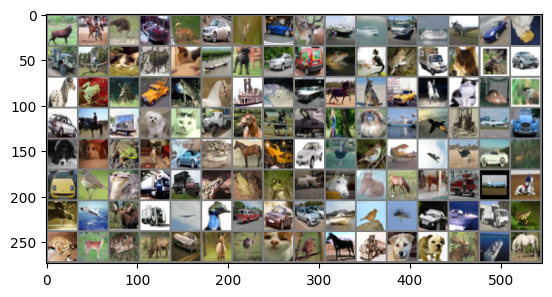

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap = 'gray')
    plt.show()

def show_batch(train_loader):
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    # images = images.squeeze(1)
    imshow(torchvision.utils.make_grid(images, nrow=16))
    # print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

show_batch(train_loader)
print(train_dataset.classes)


In [ ]:
def apply_kernel(img, kernel):
    row_img, col_img = img.shape
    row_kernel, col_kernel = kernel.shape
    row_output, col_output = row_img - row_kernel + 1, col_img - col_kernel + 1
    output = torch.zeros([row_output, col_output])

    for i in range(row_output):
        for j in range(col_output):
            output[i,j] = torch.sum(img[i:i+row_kernel,j:j+col_kernel] * kernel)
    return output



In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        output = self(images)
        loss = F.cross_entropy(output, labels)
        acc = accuracy(output, labels)
        return loss
        # return {'train_loss': loss.detach(), 'train_acc': acc}

    def validation_step(self, batch):
        images, labels = batch
        output = self(images)
        loss = F.cross_entropy(output, labels)
        acc = accuracy(output, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_losses = torch.stack(batch_losses).mean()

        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()

        return {'val_loss': epoch_losses.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch: [{}], train_loss: {:.4f}, validation_loss: {:.4f}, validation_accuracy: {:.4f}".format(
            epoch,
            result['train_loss'],
            result['val_loss'],
            # result['train_acc'],
            result['val_acc']
            ))
def accuracy(outputs, labels):
    _,predict = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(predict == labels).item() / len(predict))

In [ ]:

class Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

model = Model()

In [ ]:
model

Model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024,

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for b in self.dataloader:
              yield to_device(b, self.device)

    def __len__(self):
      return len(self.dataloader)


In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
to_device(model, device)

Model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024,

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(Model(), device)

In [ ]:
evaluate(model, val_loader)

{'val_loss': 2.303227424621582, 'val_acc': 0.09997602552175522}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch: [0], train_loss: 1.5862, validation_loss: 1.1789, validation_accuracy: 0.5688
Epoch: [1], train_loss: 1.0682, validation_loss: 0.8612, validation_accuracy: 0.6941
Epoch: [2], train_loss: 0.8005, validation_loss: 0.6541, validation_accuracy: 0.7741
Epoch: [3], train_loss: 0.6277, validation_loss: 0.5105, validation_accuracy: 0.8220
Epoch: [4], train_loss: 0.5076, validation_loss: 0.3767, validation_accuracy: 0.8676
Epoch: [5], train_loss: 0.3937, validation_loss: 0.2616, validation_accuracy: 0.9097
Epoch: [6], train_loss: 0.2924, validation_loss: 0.1603, validation_accuracy: 0.9452
Epoch: [7], train_loss: 0.2136, validation_loss: 0.1365, validation_accuracy: 0.9555
Epoch: [8], train_loss: 0.1601, validation_loss: 0.0909, validation_accuracy: 0.9718
Epoch: [9], train_loss: 0.1290, validation_loss: 0.0962, validation_accuracy: 0.9665


In [ ]:
def plot_accuracy(history):
    accuracies = [x['val_acc'] for x in history]
    val_loss = [x['val_loss'] for x in history]
    plt.plot(accuracies, '-x')
    # plt.plot(val_loss, '-*')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs No. of epoch(s)')

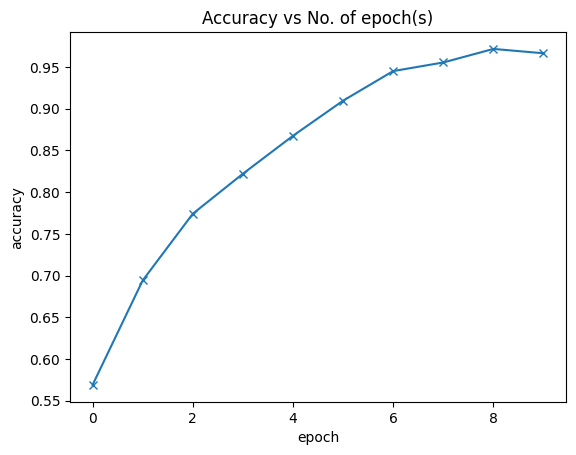

In [ ]:
plot_accuracy(history)